In [1]:
!nvidia-smi

Wed Aug  4 04:23:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp '/content/drive/MyDrive/code/실습/preprocess.py' .

In [4]:
!cp -r '/content/drive/MyDrive/code/실습/data_in' .

In [5]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 83.3 MB/s 
     |████████████████████████████████| 448 kB 54.5 MB/s 
     |████████████████████████████████| 86 kB 8.0 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [6]:
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocess import *

In [7]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+ string])
    plt.show()

In [8]:
!pwd

/content


In [9]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIG = 'data_configs.json'

In [10]:
SEED_NUM = 42
tf.random.set_seed(SEED_NUM)

In [11]:
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS, 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS, 'rb'))
prepro_config = json.load(open(DATA_IN_PATH + DATA_CONFIG, 'r'))

In [12]:
index_inputs[:10]

array([[ 9789,  3788,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [  588,  4586,  5793, 11072,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [11616,  5533,  1067, 11410, 11476, 11801,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [11616,  5533,  1067,  4005, 11410, 11476, 11801,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [  597, 10522,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],


In [13]:
len(index_inputs), len(index_outputs), len(index_targets)

(11823, 11823, 11823)

In [30]:
MODEL_NAME = 'seq2seq_kor'
BATCH_SIZE = 24
MAX_SEQUENCE = 25
EPOCH = 1
UNITS = 1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1

word2idx = prepro_config['word2idx']
idx2word = prepro_config['idx2word']
sos_idx = prepro_config['sos_symbol']
eos_idx = prepro_config['eos_symbol']
vocab_size = prepro_config['vocab_size']




In [31]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size

        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences = True , return_state = True, recurrent_initializer='glorot_uniform')


    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initial_hidden_state(self, input):
        return tf.zeros((tf.shape(input)[0], self.enc_units))

In [16]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)
        ))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


In [17]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()

        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size

        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

        self.fc = tf.keras.layers.Dense(self.vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weight = self.attention(hidden, enc_output)

        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))

        x = self.fc(output)

        return x, state, attention_weight



In [32]:
optimizer = tf.keras.optimizers.Adam()

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

In [33]:
def loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_fn(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)


In [48]:
class Seq2Seq(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, batch_size, end_token_id = EOS_INDEX ):
        super(Seq2Seq, self).__init__()
        self.end_token_id = end_token_id
        self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_size)
        self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_size)

    def call(self, x):
        input, target = x

        enc_hidden = self.encoder.initial_hidden_state(input)
        enc_output, enc_hidden = self.encoder(input, enc_hidden)

        dec_hidden = enc_hidden

        predict_tokens = []

        for t in range(target.shape[1]):
            dec_input = tf.dtypes.cast(tf.expand_dims(target[:,t], 1), tf.float32)
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_tokens.append(tf.dtypes.cast(predictions, tf.float32))

        return tf.stack(predict_tokens, axis=1)

    
    def inference(self, x):
        input = x

        enc_hidden = self.encoder.initial_hidden_state(input)
        enc_output, enc_hidden = self.encoder(input, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([word2idx[sos_idx]], 1)

        predict_tokens = []
        for t in range(MAX_SEQUENCE):
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_token = tf.argmax(predictions)

            if predict_token == self.end_token_id:
                break
            
            predict_tokens.append(predict_token)
            dec_input = tf.dtype.cast(tf.expand_dim([predict_token], 0), tf.float32)

        return tf.stack(predict_tokens, axis=0).numpy()



    


In [49]:
model = Seq2Seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE)
model.compile(loss=loss, optimizer=optimizer, metrics=[accuracy])

In [42]:
index_outputs[:10]

array([[    1,  9213,  6883, 10077, 12582,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [    1,  1838,  5983,  8742,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [    1,  6171, 10984, 11691,  7889,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [    1,  6171, 10984, 11691,  7889,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [    1,  2100,  5033, 11165,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],


In [50]:
PATH = DATA_OUT_PATH + MODEL_NAME
if not (os.path.isdir(PATH)):
    os.makedirs(os.path.join(PATH))

checkpoint_path = DATA_OUT_PATH + MODEL_NAME + "/weights.h5"

cp_callback = ModelCheckpoint( checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)

history = model.fit([index_inputs, index_outputs], index_targets, batch_size=BATCH_SIZE,
                    epochs=EPOCH, validation_split=VALIDATION_SPLIT, callbacks=[earlystop_callback, cp_callback])

444/444 [==============================] - 146s 243ms/step - loss: 1.4840 - accuracy: 0.7907 - val_loss: 1.5700 - val_accuracy: 0.7920

Epoch 00001: val_accuracy improved from -inf to 0.79196, saving model to ./data_out/seq2seq_kor/weights.h5


In [52]:
model = Seq2Seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE)

model.load_weights(os.path.join(DATA_OUT_PATH, MODEL_NAME, 'weights.h5'))

ValueError: ignored

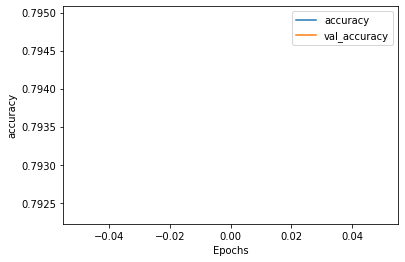

In [37]:
plot_graphs(history, 'accuracy')

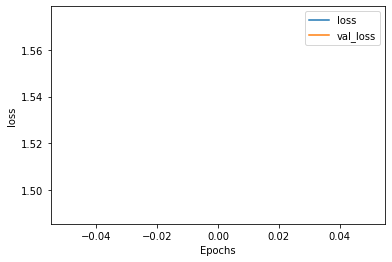

In [38]:
plot_graphs(history, 'loss')

In [51]:
query = "남자친구 승진 선물로 뭐가 좋을까?"

test_index_inputs, _ = enc_processing(query, word2idx)
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(" ".join([word2idx[str(t)] for t in predict_tokens]))

InvalidArgumentError: ignored